# Comparing OLPS algorithms on a diversified set of ETFs

Let's compare the state of the art in OnLine Portfolio Selection (OLPS) algorithms and determine if they can enhance a rabalanced passive strategy in practice. [Online Portfolio Selection: A Survey by Bin Li and Steven C. H. Hoi](http://arxiv.org/abs/1212.2129) provides the most comprehensive review of multi-period portfolio allocation optimization algorithms.  The authors [developed](https://github.com/OLPS/ and even published a paper about it) the [OLPS Toolbox](  http://www.mysmu.edu.sg/faculty/chhoi/olps/OLPS_toolbox.pdf), but here we use [Mojmir Vinkler's](https://www.linkedin.com/profile/view?id=210899853) [implementation](https://github.com/Marigold/universal-portfolios)  and extend [his comparison](http://nbviewer.ipython.org/github/Marigold/universal-portfolios/blob/master/On-line%20portfolios.ipynb) to a more recent timeline with a set of ETFs to avoid survivorship bias (as suggested by [Ernie Chan](http://epchan.blogspot.cz/2007/01/universal-portfolios.html)) and idiosyncratic risk.

Vinkler does all the hard work in his [thesis](http://is.muni.cz/th/358102/prif_m/?lang=en;id=183901), and concludes  that Universal Portfolios work practically the same as Constant Rebalanced Portfolios, and work better for an uncorrelated set of small and volatile stocks.  Here I'm looking to find if any strategy is applicable to a set of ETFs.

The agorithms compared are:

Type | Name | Algo | Reference 
-----|------|------|----
Benchmark | BAH | Buy and Hold |
Benchmark | CRP | Constant Rebalanced Portfolio | T. Cover. [Universal Portfolios](http://www-isl.stanford.edu/~cover/papers/paper93.pdf), 1991.
Benchmark | BCRP | Best Constant Rebalanced Portfolio | T. Cover. [Universal Portfolios](http://www-isl.stanford.edu/~cover/papers/paper93.pdf), 1991.
Follow-the-Winner | UP | Universal Portfolio | T. Cover. [Universal Portfolios](http://www-isl.stanford.edu/~cover/papers/paper93.pdf), 1991.
Follow-the-Winner | EG | Exponential Gradient |  Helmbold, David P., et al. [On‐Line Portfolio Selection Using Multiplicative Updates](http://www.cis.upenn.edu/~mkearns/finread/helmbold98line.pdf) Mathematical Finance 8.4 (1998): 325-347.
Follow-the-Winner | ONS | Online Newton Step | A. Agarwal, E. Hazan, S. Kale, R. E. Schapire. [Algorithms for Portfolio Management based on the Newton Method](http://machinelearning.wustl.edu/mlpapers/paper_files/icml2006_AgarwalHKS06.pdf), 2006.
Follow-the-Loser | Anticor | Anticorrelation | A. Borodin, R. El-Yaniv, and V. Gogan. [Can we learn to beat the best stock](http://arxiv.org/abs/1107.0036), 2005
Follow-the-Loser |PAMR | Passive Aggressive Mean Reversion  |  B. Li, P. Zhao, S. C.H. Hoi, and V. Gopalkrishnan. [Pamr: Passive aggressive mean reversion strategy for portfolio selection](http://www.cais.ntu.edu.sg/~chhoi/paper_pdf/PAMR_ML_final.pdf), 2012.
Follow-the-Loser |CWMR | Confidence Weighted Mean Reversion |  B. Li, S. C. H. Hoi, P. L. Zhao, and V. Gopalkrishnan.[Confidence weighted mean reversion strategy for online portfolio selection](http://jmlr.org/proceedings/papers/v15/li11b/li11b.pdf), 2013.        
Follow-the-Loser | OLMAR | Online Moving Average Reversion| [On-Line Portfolio Selection with Moving Average Reversion](http://arxiv.org/abs/1206.4626)
Follow-the-Loser |RMR | Robust Median Reversion | D. Huang, J. Zhou, B. Li, S. C.vH. Hoi, S. Zhou [Robust Median Reversion Strategy for On-Line Portfolio Selection](http://ijcai.org/papers13/Papers/IJCAI13-296.pdf), 2013.
Pattern Matching | Kelly | Kelly fractional betting |[Kelly Criterion](http://en.wikipedia.org/wiki/Kelly_criterion#Application_to_the_stock_market)
Pattern Matching | BNN | nonparametric nearest neighbor log-optimal | L. Gyorfi, G. Lugosi, and F. Udina. [Nonparametric kernel based sequential investment strategies](http://papers.ssrn.com/sol3/papers.cfm?abstract_id=889976). Mathematical Finance 16 (2006) 337–357.
Pattern Matching | CORN | correlation-driven nonparametric learning | B. Li, S. C. H. Hoi, and V. Gopalkrishnan. [Corn: correlation-driven nonparametric learning approach for portfolio selection](http://www.cais.ntu.edu.sg/~chhoi/paper_pdf/TIST-CORN.pdf), 2011.

We pick 6 ETFs to avoid survivorship bias and capture broad market diversification. We select the longest running ETF per assset class: [VTI](https://www.google.com/finance?q=VTI), [EFA](https://www.google.com/finance?q=EFA), [EEM](https://www.google.com/finance?q=EFA), [TLT](https://www.google.com/finance?q=TLT), [TIP](https://www.google.com/finance?q=TIP), [VNQ](https://www.google.com/finance?q=VNQ) . In addition to the BAH, CRP and BCRP benchmarks, we consider holding [SPY](https://www.google.com/finance?q=SPY) at 100% as a benchmark. We train and select the best parameters on market data from 2005-2012 inclusive (8 years), and test on 2013-2014 inclusive (2 years). 

In [ ]:
# You will first need to either download or install universal-portfolios from Vinkler
# one way to do it is uncomment the line below and execute
#!pip install git+git@github.com:Marigold/universal-portfolios.git

Initialize and set debugging level to `debug` to track progress.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import six
from universal import tools
from universal import algos
import logging
# we would like to see algos progress
logging.basicConfig(format='%(asctime)s %(message)s', level=logging.DEBUG)

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (16, 10) # increase the size of graphs
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['lines.linewidth'] = 1
default_color_cycle = mpl.rcParams['axes.color_cycle'] # save this as we will want it back later

In [2]:
# note what versions we are on:
import sys
print('Python: '+sys.version)
print('Pandas: '+pd.__version__)

Python: 2.7.9 |Anaconda 2.2.0 (x86_64)| (default, Dec 15 2014, 10:37:34) 
[GCC 4.2.1 (Apple Inc. build 5577)]
Pandas: 0.15.2


# Loading the data

We pick 6 ETFs to avoid survivorship bias and capture broad market diversification. We select the longest running ETF per assset class: [VTI](https://www.google.com/finance?q=VTI), [EFA](https://www.google.com/finance?q=EFA), [EEM](https://www.google.com/finance?q=EFA), [TLT](https://www.google.com/finance?q=TLT), [TIP](https://www.google.com/finance?q=TIP), [VNQ](https://www.google.com/finance?q=VNQ) . In addition to the BAH, CRP and BCRP benchmarks, we consider holding [SPY](https://www.google.com/finance?q=SPY) at 100% as a benchmark. 

We want to train on market data from 2005-2012 inclusive (8 years), and test on 2013-2014 inclusive (2 years). But at this point we accept the default parameters for the respective algorithms and we essentially are looking at two independent time periods.  In the future we will want to optimize the paramaters on the train set.

In [3]:
from pandas.io.data import DataReader
from datetime import datetime

# load data from Yahoo
etfs = ['VTI', 'EFA', 'EEM', 'TLT', 'TIP', 'VNQ']
benchmark = ['SPY']
train_start = datetime(2005,1,1)
train_end   = datetime(2012,12,31)
test_start  = datetime(2013,1,1) 
test_end    = datetime(2014,12,31)
train = DataReader(etfs, 'yahoo', start=train_start, end=train_end)['Adj Close']
test  = DataReader(etfs, 'yahoo', start=test_start, end=test_end)['Adj Close']
train_b = DataReader(benchmark, 'yahoo', start=train_start, end=train_end)['Adj Close']
test_b  = DataReader(benchmark, 'yahoo', start=test_start, end=test_end)['Adj Close']

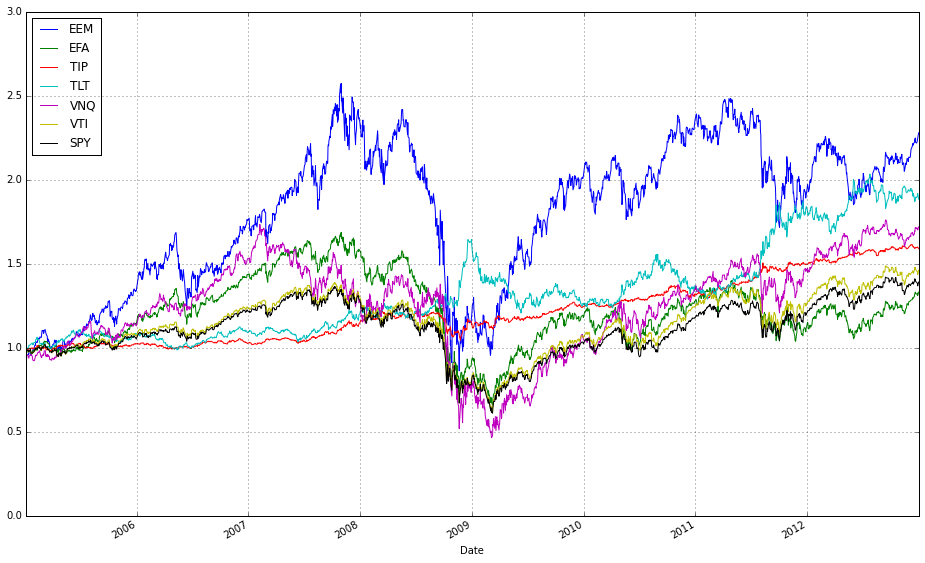

In [4]:
# plot normalized prices of the train set
ax1 = (train / train.iloc[0,:]).plot()
(train_b / train_b.iloc[0,:]).plot(ax=ax1)

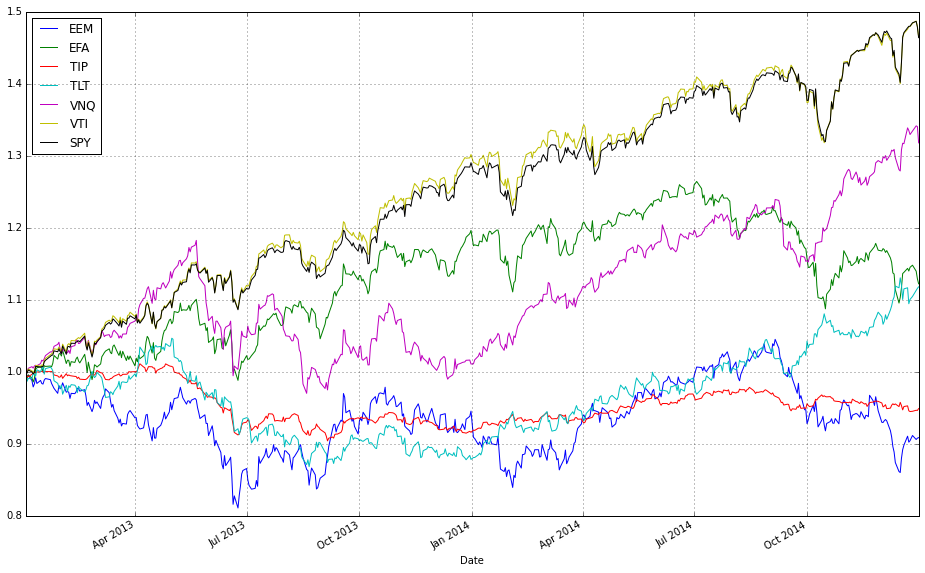

In [5]:
# plot normalized prices of the test set
ax2 = (test / test.iloc[0,:]).plot()
(test_b / test_b.iloc[0,:]).plot(ax=ax2)

# Comparing the Algorithms

In [6]:
#list all the algos
olps_algos = [
algos.Anticor(),
algos.BAH(),
algos.BCRP(),
algos.BNN(),
algos.CORN(),
algos.CRP(),
algos.CWMR(),
algos.EG(),
algos.Kelly(),
algos.OLMAR(),
algos.ONS(),
algos.PAMR(),
# algos.RMR(),
algos.UP()
]

In [7]:
# put all the algos in a dataframe
algo_names = [a.__class__.__name__ for a in olps_algos]
algo_data = ['algo', 'results', 'profit', 'sharpe', 'information', 'annualized_return', 'drawdown_period','winning_pct']
metrics = algo_data[2:]
olps_train = pd.DataFrame(index=algo_names, columns=algo_data)
olps_train.algo = olps_algos

At this stage we don't train any of the algos and we take their defaults.  We should train all the algos first to find the best parameters for each.

In [8]:
# run all algos - this takes more than a minute
for name, alg in zip(olps_train.index, olps_train.algo):
    olps_train.ix[name,'results'] = alg.run(train)

In [9]:
# Let's make sure the fees are set to 0 at first
for k, r in olps_train.results.iteritems():
    r.fee = 0.0

In [10]:
# we need 14 colors for the plot
n_lines = 14
color_idx = np.linspace(0, 1, n_lines)
mpl.rcParams['axes.color_cycle']=[plt.cm.rainbow(i) for i in color_idx]

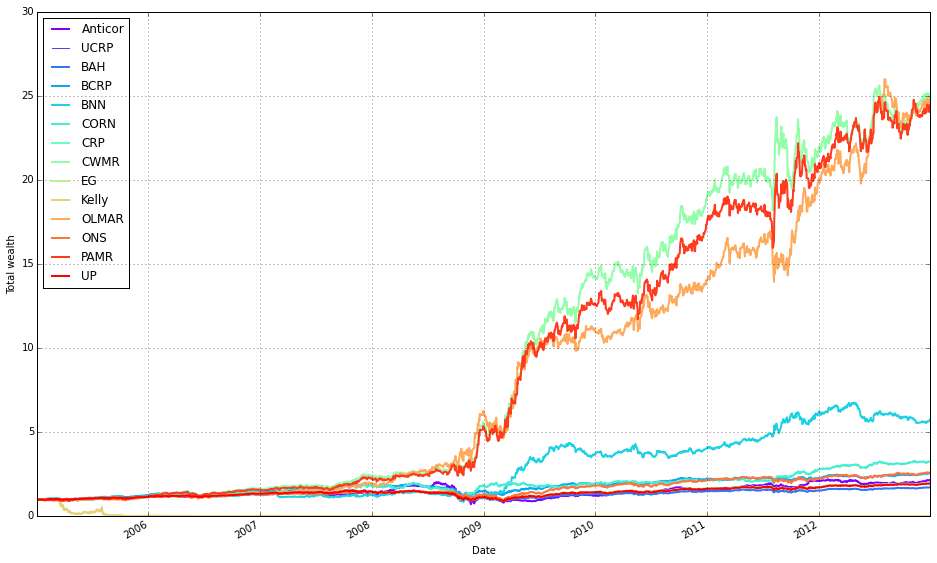

In [11]:
# plot as if we had no fees
# get the first result so we can grab the figure axes from the plot
ax = olps_train.results[0].plot(assets=False, weights=False, ucrp=True, portfolio_label=olps_train.index[0])
for k, r in olps_train.results.iteritems():
    if k == olps_train.results.keys()[0]: # skip the first item because we have it already
        continue
    r.plot(assets=False, weights=False, ucrp=False, portfolio_label=k, ax=ax[0])

In [12]:
def olps_stats(df):
    for name, r in df.results.iteritems():
        df.ix[name,'profit'] = r.profit_factor
        df.ix[name,'sharpe'] = r.sharpe
        df.ix[name,'information'] = r.information
        df.ix[name,'annualized_return'] = r.annualized_return * 100
        df.ix[name,'drawdown_period'] = r.drawdown_period
        df.ix[name,'winning_pct'] = r.winning_pct * 100
    return df

In [13]:
olps_stats(olps_train)
olps_train[metrics].sort('profit', ascending=False)

,profit,sharpe,information,annualized_return,drawdown_period,winning_pct
CWMR,1.30964,1.29867,1.419667,49.69137,134,54.7047
PAMR,1.307667,1.284661,1.405146,49.15968,113,54.55912
OLMAR,1.303725,1.275474,1.358441,49.43,128,54.95495
BNN,1.16316,0.7406326,0.597467,24.49535,516,53.74625
ONS,1.124495,0.5324337,0.4103257,12.69247,301,54.77137
CORN,1.120664,0.5868915,0.3335868,16.03551,619,54.42346
BCRP,1.113103,0.5587799,0.3926754,12.47399,493,52.53479
CRP,1.096184,0.4684842,0,8.883679,691,54.07555
EG,1.095291,0.4654109,-0.5754063,8.796127,691,54.02584
UP,1.093631,0.4597145,-0.5784247,8.622724,720,54.07555


In [14]:
# Let's add fees of 0.1% per transaction (we pay $1 for every $1000 of stocks bought or sold).
for k, r in olps_train.results.iteritems():
    r.fee = 0.001

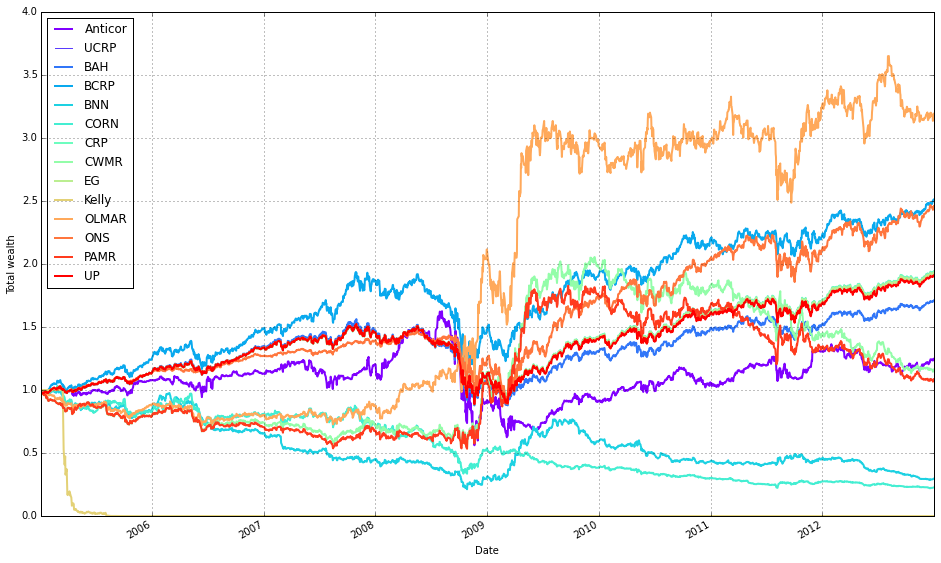

In [15]:
# plot with fees
# get the first result so we can grab the figure axes from the plot
ax = olps_train.results[0].plot(assets=False, weights=False, ucrp=True, portfolio_label=olps_train.index[0])
for k, r in olps_train.results.iteritems():
    if k == olps_train.results.keys()[0]: # skip the first item because we have it already
        continue
    r.plot(assets=False, weights=False, ucrp=False, portfolio_label=k, ax=ax[0])

Notice how Kelly crashes and how OLMAR floats to the top after some high volatility.  

In [16]:
olps_stats(olps_train)
olps_train[metrics].sort('profit', ascending=False)

,profit,sharpe,information,annualized_return,drawdown_period,winning_pct
ONS,1.116896,0.5017011,0.3281846,11.91852,303,54.64481
BCRP,1.110684,0.5474909,0.3639968,12.20745,496,52.50869
OLMAR,1.103785,0.4692946,0.2657746,15.62398,808,50.97354
CRP,1.09371,0.456983,-5.658032,8.656748,696,53.99901
EG,1.09293,0.4544007,-1.921296,8.579679,720,53.94933
UP,1.091477,0.4496153,-1.00974,8.42583,721,54.04868
BAH,1.074893,0.3844829,-0.6506861,6.947344,874,54.09836
Anticor,1.019879,0.08123565,-0.2464923,2.801569,1108,51.76881
CWMR,1.013093,0.06186626,-0.3053956,1.904562,995,47.28991
PAMR,1.007116,0.03362724,-0.3451079,1.033495,996,46.54401


# Run on the Test Set

In [17]:
# create the test set dataframe
olps_test  = pd.DataFrame(index=algo_names, columns=algo_data)
olps_test.algo  = olps_algos

In [18]:
# run all algos
for name, alg in zip(olps_test.index, olps_test.algo):
    olps_test.ix[name,'results'] = alg.run(test)

In [19]:
# Let's make sure the fees are 0 at first
for k, r in olps_test.results.iteritems():
    r.fee = 0.0

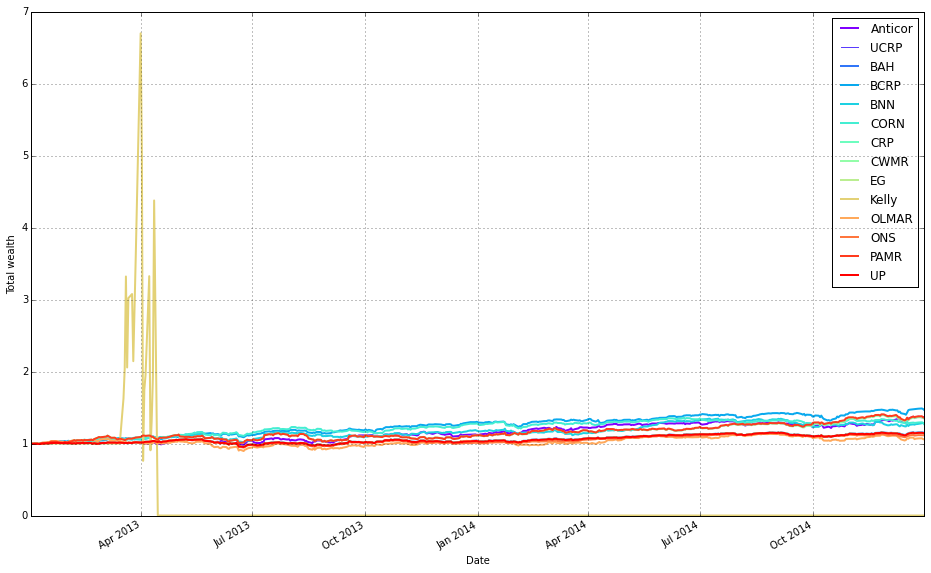

In [20]:
# plot as if we had no fees
# get the first result so we can grab the figure axes from the plot
ax = olps_test.results[0].plot(assets=False, weights=False, ucrp=True, portfolio_label=olps_test.index[0])
for k, r in olps_test.results.iteritems():
    if k == olps_test.results.keys()[0]: # skip the first item because we have it already
        continue
    r.plot(assets=False, weights=False, ucrp=False, portfolio_label=k, ax=ax[0])

### Kelly went wild and crashed, so let's remove it from the mix

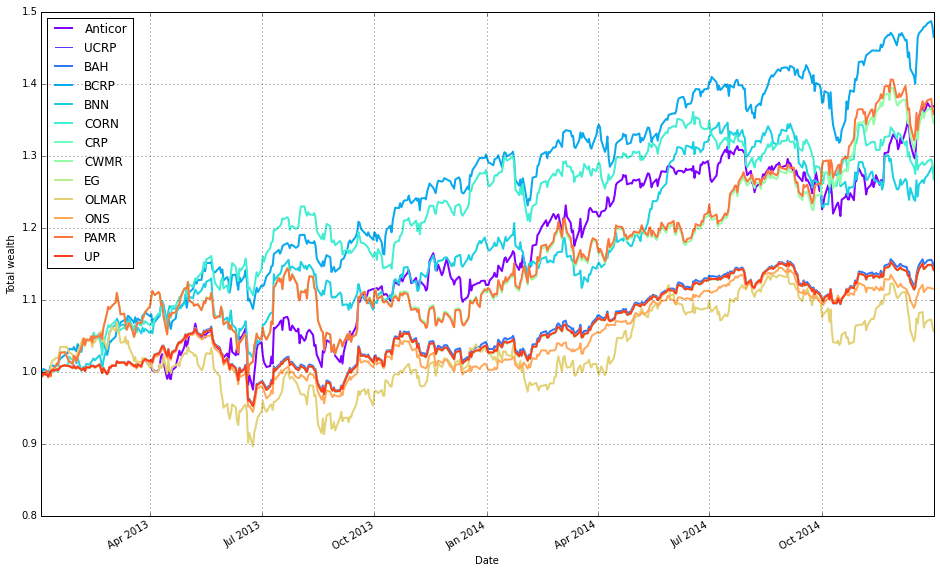

In [21]:
# plot as if we had no fees
# get the first result so we can grab the figure axes from the plot
ax = olps_test.results[0].plot(assets=False, weights=False, ucrp=True, portfolio_label=olps_test.index[0])
for k, r in olps_test.results.iteritems():
    if k == olps_test.results.keys()[0] or k == 'Kelly': # skip the first item because we have it already
        continue
    r.plot(assets=False, weights=False, ucrp=False, portfolio_label=k, ax=ax[0])

In [22]:
olps_stats(olps_test)
olps_test[metrics].sort('profit', ascending=False)

,profit,sharpe,information,annualized_return,drawdown_period,winning_pct
BCRP,1.323158,1.687346,1.75396,21.09194,36,59.04573
Anticor,1.213151,1.119712,0.9792509,17.03448,86,56.88623
PAMR,1.198056,1.066684,0.8037021,16.56317,127,53.90782
CWMR,1.192981,1.038446,0.7643975,16.02498,127,54.10822
CORN,1.187963,1.042635,0.625535,12.58479,136,55.4672
BNN,1.18066,0.9848432,0.5932079,13.03065,122,56.6
BAH,1.150074,0.8247777,0.5070828,7.09091,193,55.666
UP,1.147022,0.807597,0.338926,6.840418,193,55.4672
EG,1.1467,0.8053731,0.491308,6.826939,194,54.87078
CRP,1.146508,0.804342,0,6.814086,194,54.87078


Wow, OLMAR is at the bottom of the list. Remember, we really didn't do any training, but if we had selected OLMAR at the beginning of 2013 based on past performance, we would not have beat BAH. Hm.

# Focusing on OLMAR

Instead of using the default parameters, we will test several `window` parameters to see if we can get OLMAR to improve.

In [23]:
# we need need fewer colors so let's reset the colors_cycle
mpl.rcParams['axes.color_cycle']= default_color_cycle

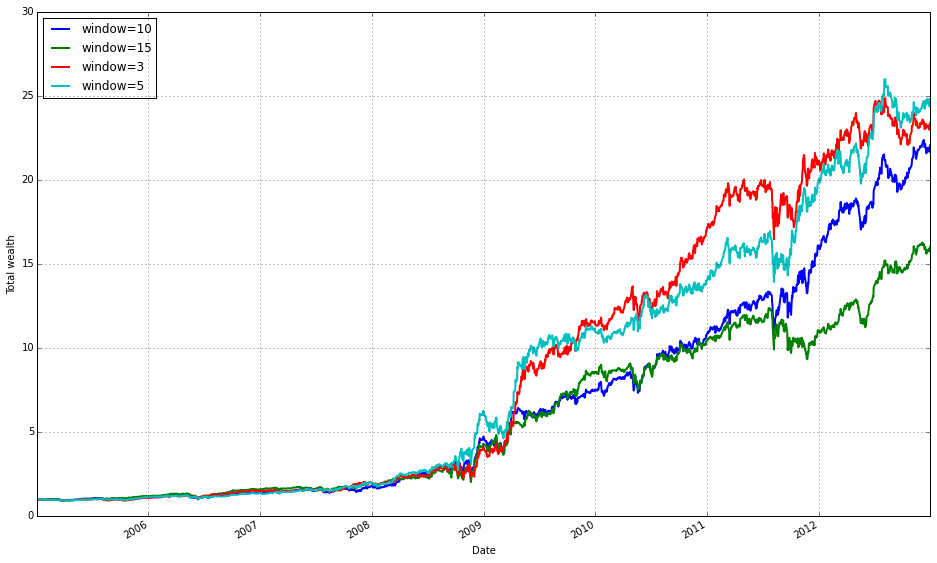

In [24]:
train_olmar = algos.OLMAR.run_combination(train, window=[3,5,10,15], eps=10)
#print(train_olmar.summary())
train_olmar.plot()

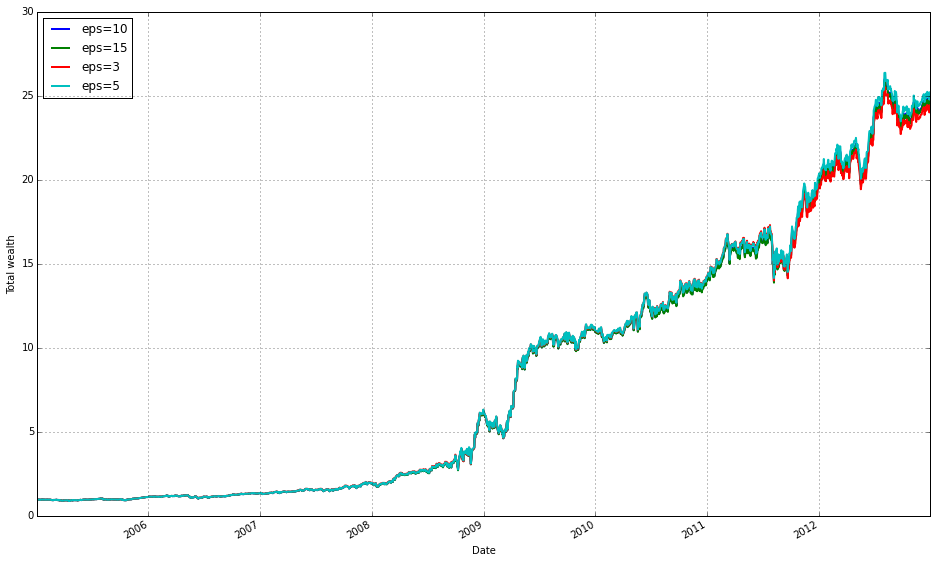

In [25]:
train_olmar = algos.OLMAR.run_combination(train, window=5, eps=[3,5,10,15])
#print(train_olmar.summary())
train_olmar.plot()

In this instance a window 3 is the best, but the recommendation is for a window of 5, and other runs I have done I found 5 to be the best.  Let's vary eps.

In [26]:
train_olmar[0].equity.iloc[-1]#.argmax()

24.458732048219279

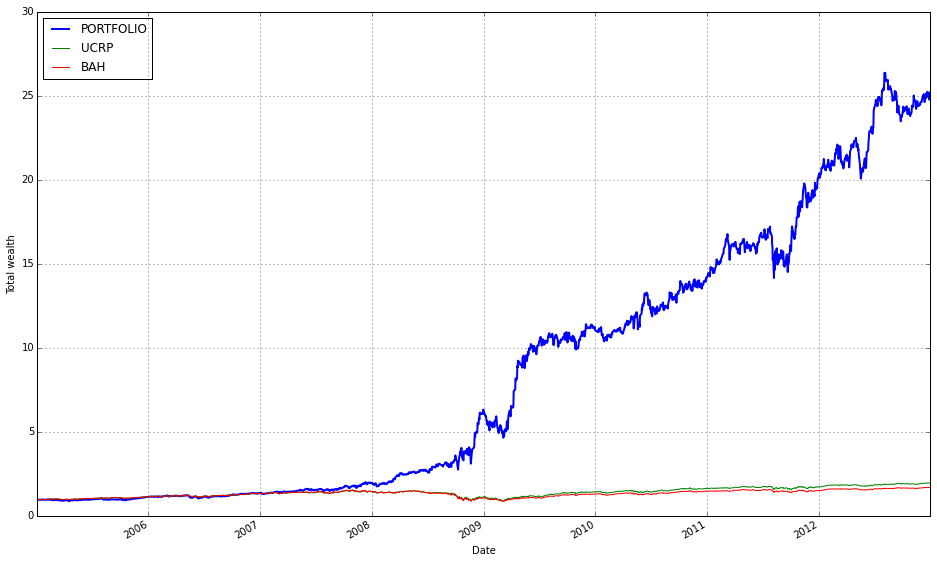

In [27]:
# OLMAR vs UCRP
best_olmar = train_olmar[1]
best_olmar.plot(ucrp=True, bah=True, weights=False, assets=False)

In [28]:
# let's print the stats
print(best_olmar.summary())

Summary:
    Profit factor: 1.31
    Sharpe ratio: 1.28
    Information ratio (wrt UCRP): 1.37
    Annualized return: 49.73%
    Longest drawdown: 128 days
    Winning days: 55.0%
        


Let's see how individual ETFs contribute to portfolio equity.

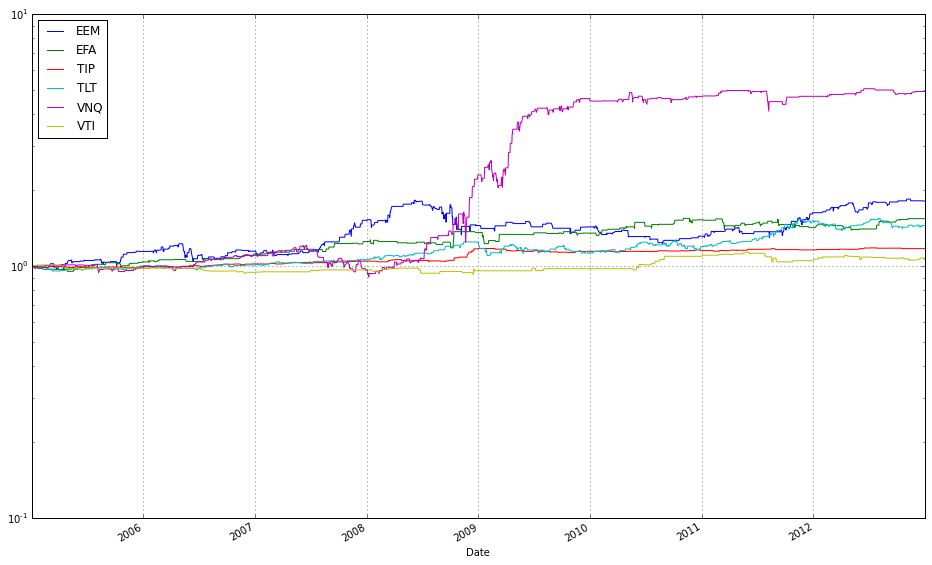

In [29]:
best_olmar.plot_decomposition(legend=True, logy=True)

Let's highlight the magnitude of the highest contributing ETF by removing the log scale and looking at it directly.

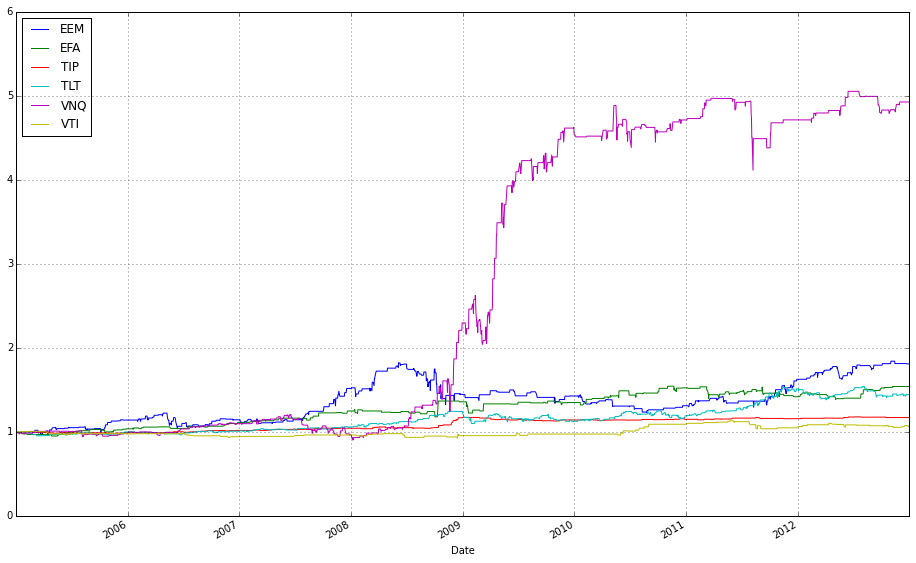

In [30]:
best_olmar.plot_decomposition(legend=True, logy=False)

Let's look at portfolio allocations, but it seems hard to read.

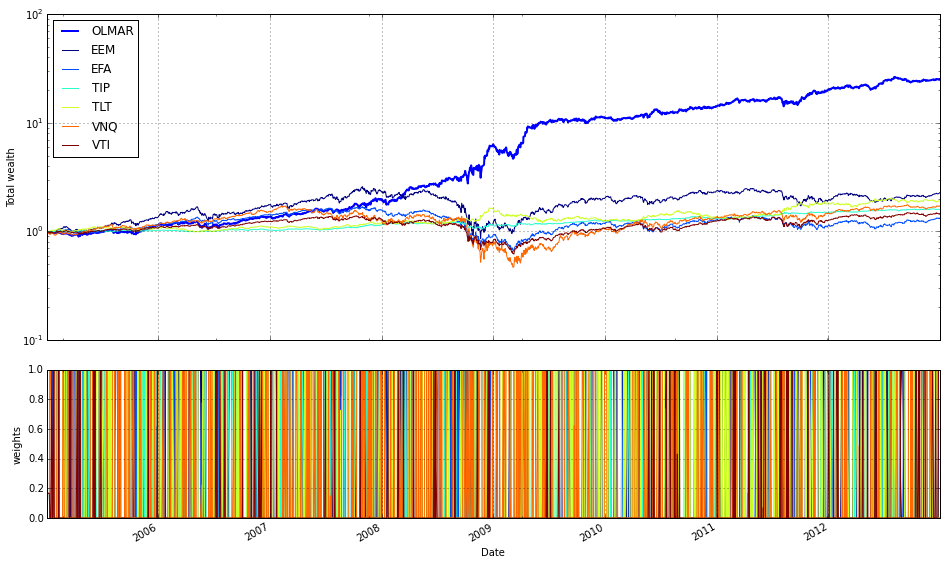

In [31]:
best_olmar.plot(weights=True, assets=True, ucrp=False, logy=True, portfolio_label='OLMAR')

VNQ is the big driver of wealth (log scale). Let's test the strategy by removing the most profitable stock and comparing Total Wealth.

Summary:
    Profit factor: 1.23
    Sharpe ratio: 1.02
    Information ratio (wrt UCRP): 0.99
    Annualized return: 32.37%
    Longest drawdown: 153 days
    Winning days: 54.7%
        


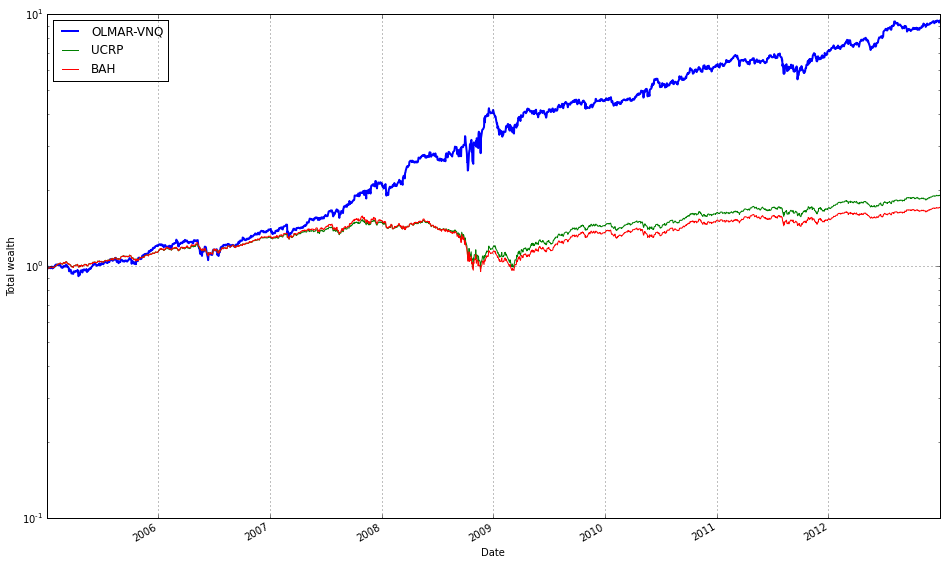

In [32]:
# find the name of the most profitable asset
most_profitable = best_olmar.equity_decomposed.iloc[-1].argmax()

# rerun algorithm on data without it
result_without = algos.OLMAR().run(train.drop([most_profitable], 1))

# and print results
print(result_without.summary())
result_without.plot(weights=False, assets=False, bah=True, ucrp=True, logy=True, portfolio_label='OLMAR-VNQ')

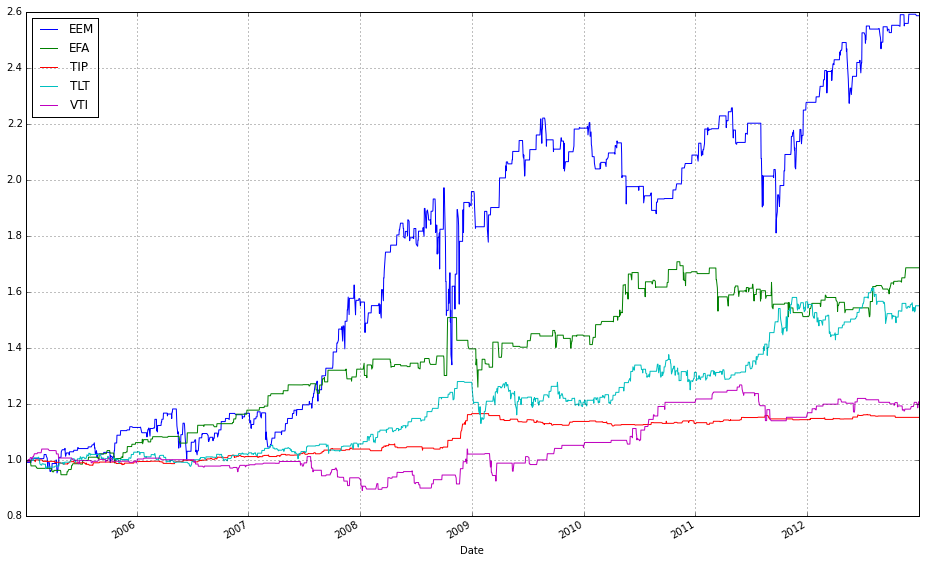

In [33]:
result_without.plot_decomposition(legend=True, logy=False)

Let's add fees of 0.1% per transaction (we pay \$1 for every \$1000 of stocks bought or sold).

Summary:
    Profit factor: 1.11
    Sharpe ratio: 0.48
    Information ratio (wrt UCRP): 0.28
    Annualized return: 15.97%
    Longest drawdown: 808 days
    Winning days: 51.1%
        


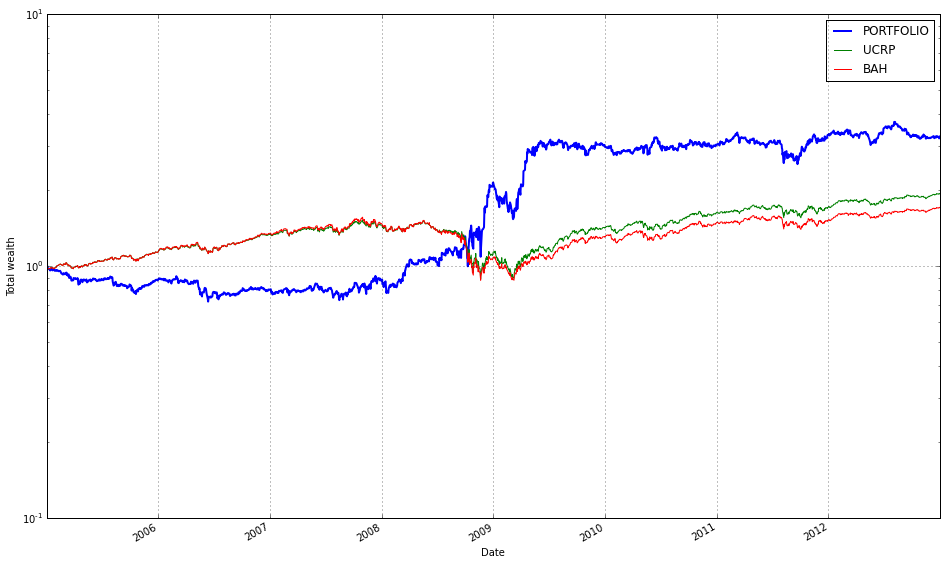

In [34]:
best_olmar.fee = 0.001
print(best_olmar.summary())
best_olmar.plot(weights=False, assets=False, bah=True, ucrp=True, logy=True)

The results now fall, with a Sharpe Ratio below the ~0.5 market Sharpe, and an annualized return that has been cut in half due to fees. Not exactly stunning results for all that trading.

# OLMAR Starting in 2010

The 2008-2009 recession was unique.  Let's try it all again starting in 2010, with a train set from 2010-2013 inclusive, and a test set of 2014.

In [35]:
# load data from Yahoo
train_start_2010= datetime(2010,1,1)
train_end_2010 = datetime(2013,12,31)
test_start_2010 = datetime(2014,1,1)
test_end_2010 = datetime(2014,12,31)
train_2010 = DataReader(etfs, 'yahoo', start=train_start_2010, end=train_end_2010)['Adj Close']
test_2010  = DataReader(etfs, 'yahoo', start=test_start_2010,  end=test_end_2010)['Adj Close']

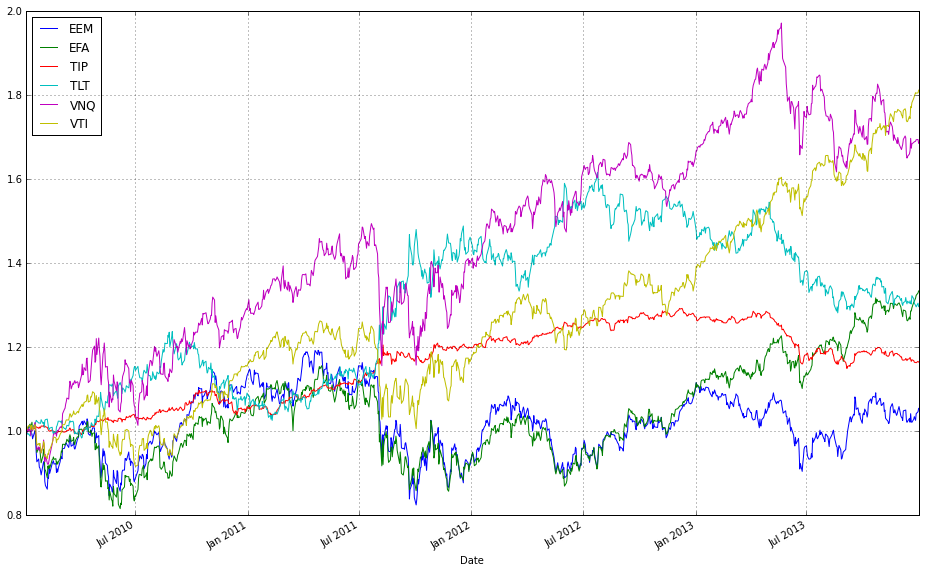

In [36]:
# plot normalized prices of these stocks
(train_2010 / train_2010.iloc[0,:]).plot()

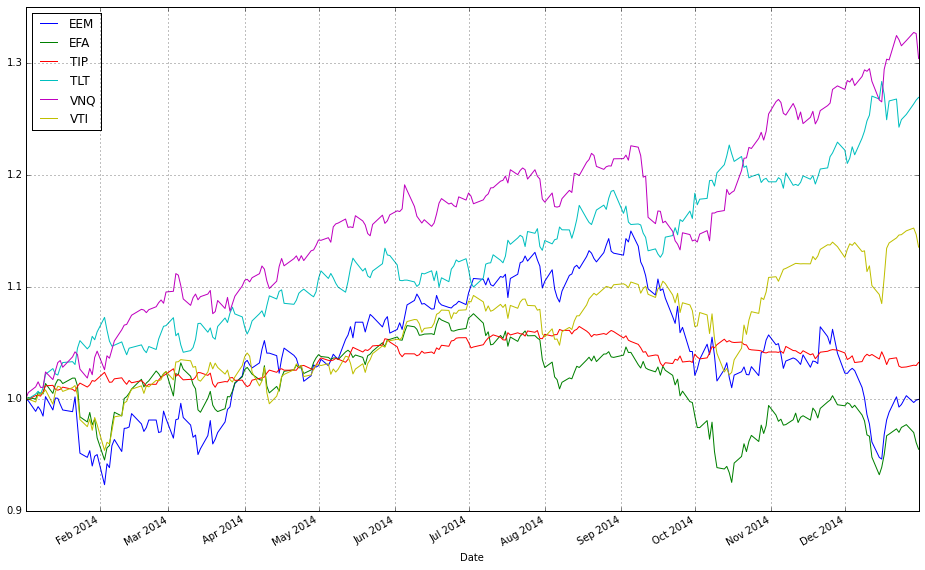

In [37]:
# plot normalized prices of these stocks
(test_2010 / test_2010.iloc[0,:]).plot()

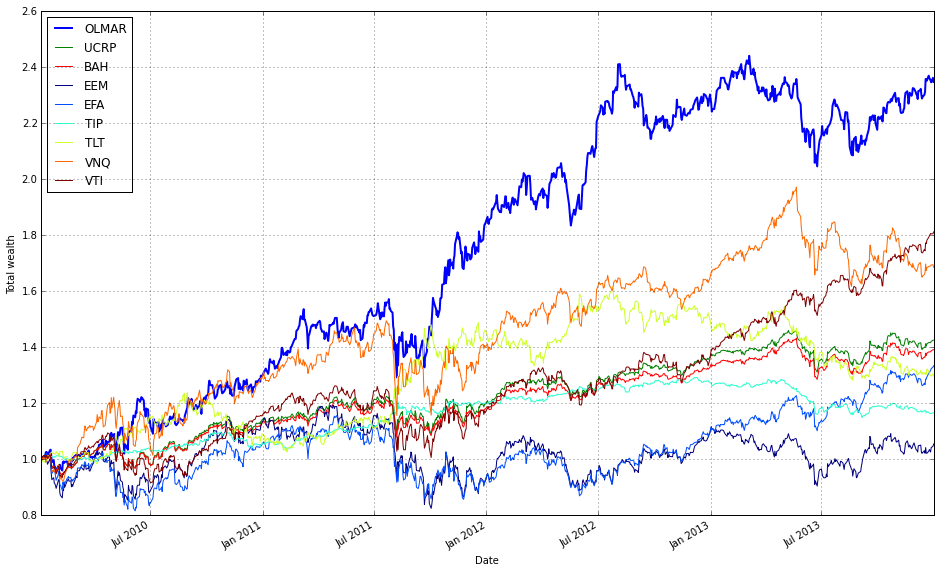

In [38]:
train_olmar_2010 = algos.OLMAR().run(train_2010)
train_olmar_2010.plot(assets=True, weights=False, ucrp=True, bah=True, portfolio_label='OLMAR')

In [39]:
print(train_olmar_2010.summary())

Summary:
    Profit factor: 1.19
    Sharpe ratio: 1.00
    Information ratio (wrt UCRP): 0.75
    Annualized return: 23.83%
    Longest drawdown: 209 days
    Winning days: 55.1%
        


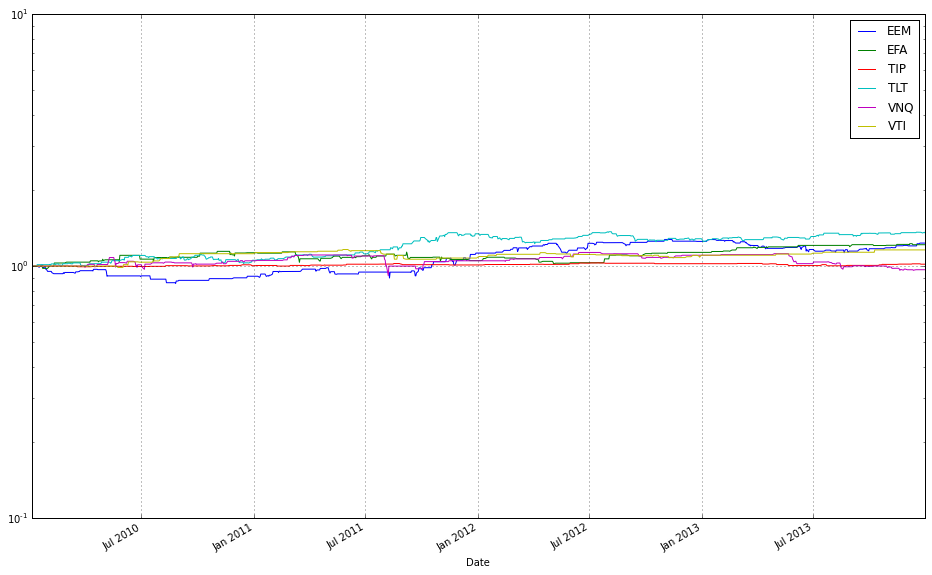

In [40]:
train_olmar_2010.plot_decomposition(legend=True, logy=True)

Not bad, with a Sharpe at 1 and no one ETF dominating the portfolio.  Now let's see how it fairs in 2014. 

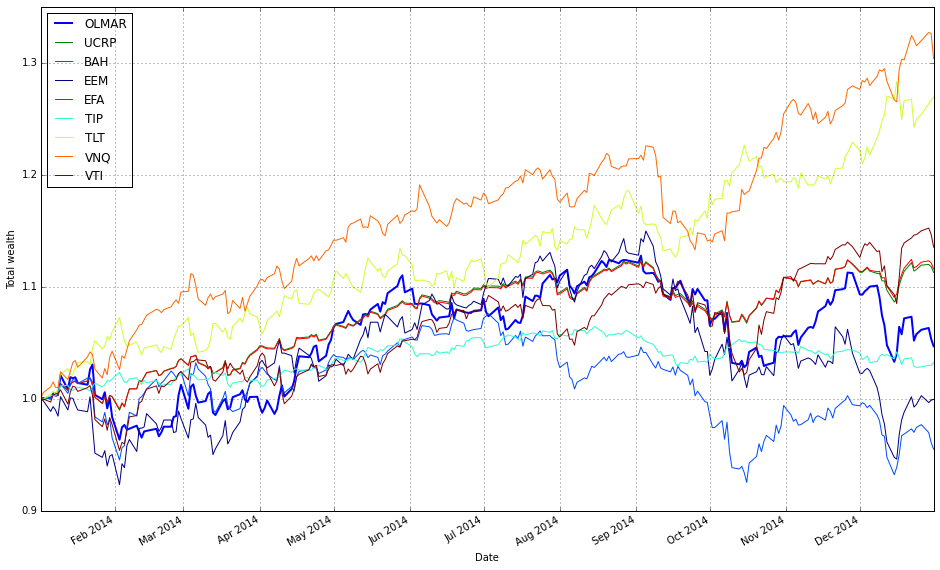

In [41]:
test_olmar_2010 = algos.OLMAR().run(test_2010)
test_olmar_2010.plot(assets=True, weights=False, ucrp=True, bah=True, portfolio_label='OLMAR')

In [42]:
print(test_olmar_2010.summary())

Summary:
    Profit factor: 1.06
    Sharpe ratio: 0.36
    Information ratio (wrt UCRP): -0.63
    Annualized return: 4.72%
    Longest drawdown: 83 days
    Winning days: 57.9%
        


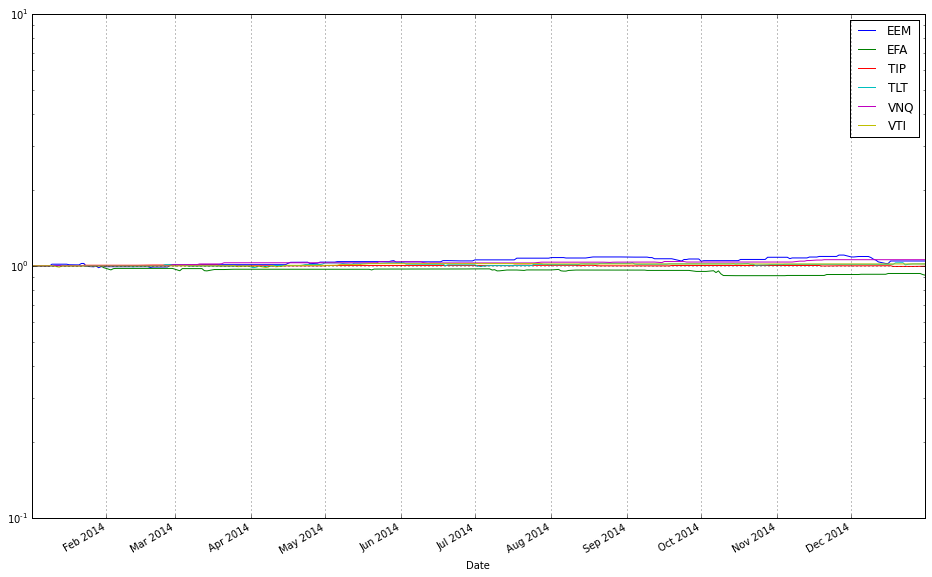

In [43]:
test_olmar_2010.plot_decomposition(legend=True, logy=True)

We just happen to be looking at a different time period and now the Sharpe drops below 0.5 and OLMAR fails to beat BAH.  Again, not good.

# SPY / TLT portfolio comparison

Let's step back and simplify this by looking at OLMAR on a SPY and TLT portfolio.  We should also compare this portfolio to a rebalanced 70/30 mix of SPY and TLT.

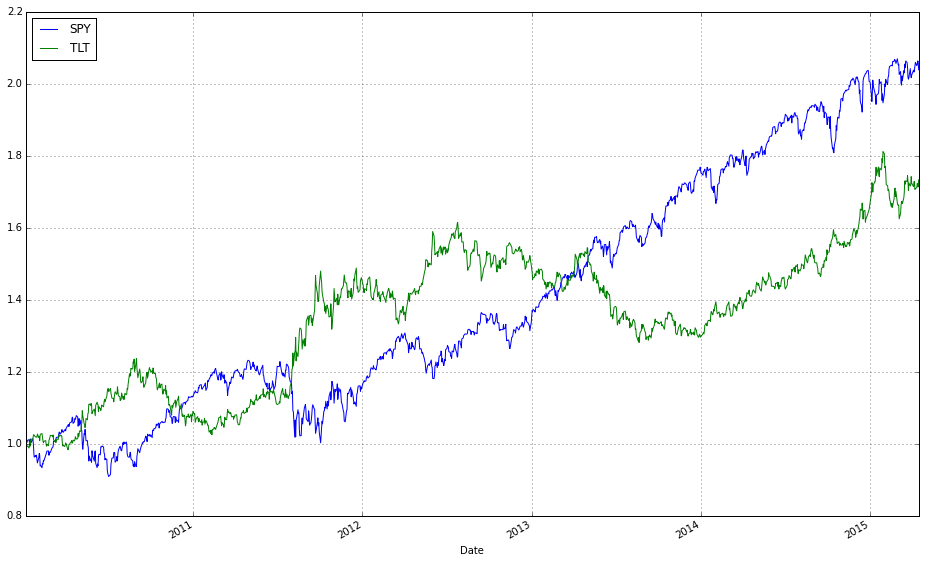

In [44]:
# load data from Yahoo
spy_tlt_data = DataReader(['SPY', 'TLT'], 'yahoo', start=datetime(2010,1,1))['Adj Close']

# plot normalized prices of these stocks
(spy_tlt_data / spy_tlt_data.iloc[0,:]).plot()

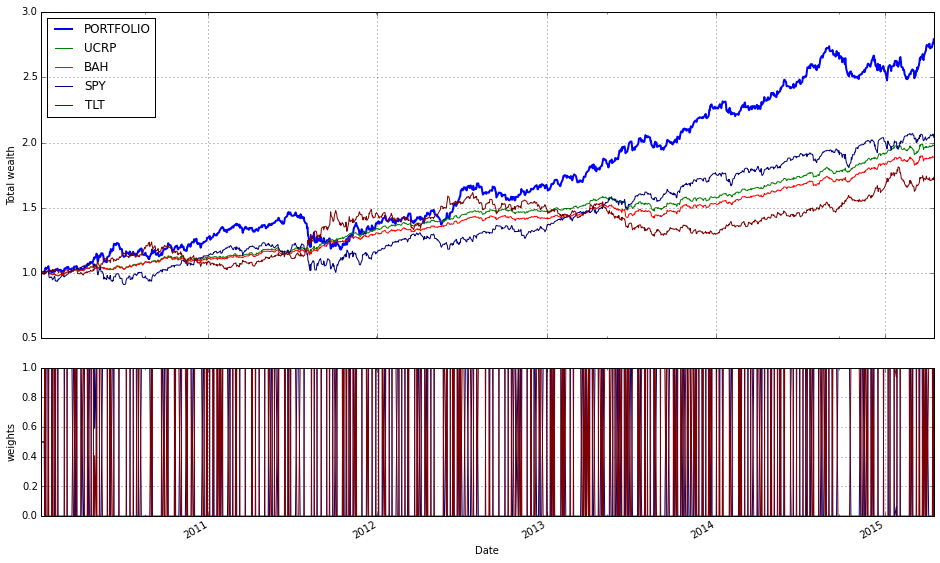

In [45]:
spy_tlt_olmar_2010 = algos.OLMAR().run(spy_tlt_data)
spy_tlt_olmar_2010.plot(assets=True, weights=True, ucrp=True, bah=True)

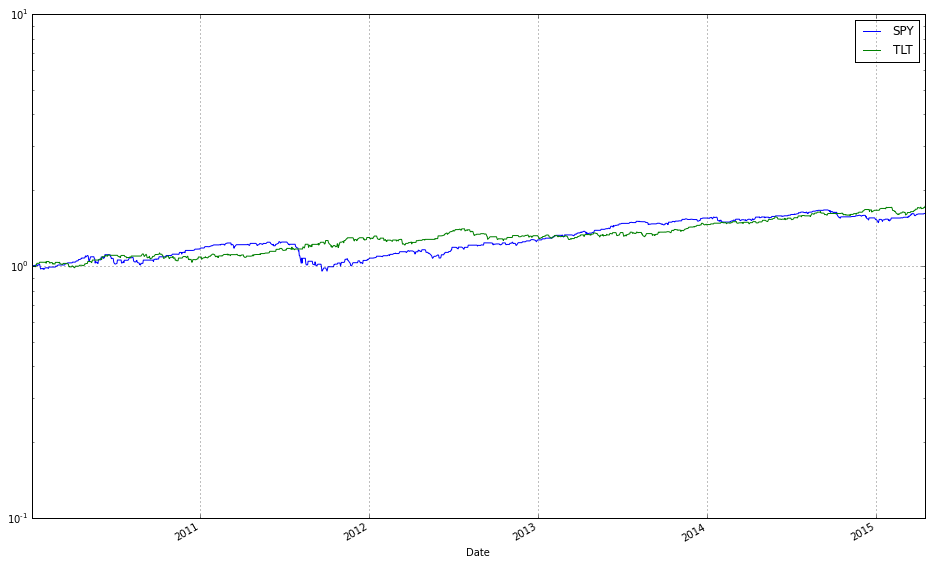

In [46]:
spy_tlt_olmar_2010.plot_decomposition(legend=True, logy=True)

In [47]:
print(spy_tlt_olmar_2010.summary())

Summary:
    Profit factor: 1.22
    Sharpe ratio: 1.19
    Information ratio (wrt UCRP): 0.48
    Annualized return: 21.44%
    Longest drawdown: 210 days
    Winning days: 56.2%
        


Now OLMAR looks better.  Is it's simply the nature of an up market.  

# Conclusion

More investigation is required to determine which algorithm is best for this set of equities, and if any of the algorithms beat CRP, SPY, or a rebalanced portfolio.